In [1]:
batch_size = 4000
lr = 0.002
num_epoch = 500
number_of_features = 41
number_of_class_attack_cat = 10
number_of_class_label = 2
hyper_parameter1=128
hyper_parameter2=64
hyper_parameter3=32
hyper_parameter4=16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

plt.rcParams.update({'font.size': 15})

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
UNSW_NB15 = pd.read_csv("/content/drive/MyDrive/UNSW_NB15.csv")

UNSW_NB15.loc[UNSW_NB15["attack_cat"] == "Worms", "attack_cat"] = "G1"
UNSW_NB15.loc[UNSW_NB15["attack_cat"] == "Shellcode", "attack_cat"] = "G1"
UNSW_NB15.loc[UNSW_NB15["attack_cat"] == "Reconnaissance", "attack_cat"] = "G1"
UNSW_NB15.loc[UNSW_NB15["attack_cat"] == "Exploits", "attack_cat"] = "G1"

UNSW_NB15.loc[UNSW_NB15["attack_cat"] == "DoS", "attack_cat"] = "G2"
UNSW_NB15.loc[UNSW_NB15["attack_cat"] == "Analysis", "attack_cat"] = "G2"
UNSW_NB15.loc[UNSW_NB15["attack_cat"] == "Backdoor", "attack_cat"] = "G2"

UNSW_NB15_category = UNSW_NB15.copy()
UNSW_NB15_label = UNSW_NB15.copy()

UNSW_NB15

,Unnamed: 0,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0,1,0.121478,tcp,-,FIN,6,4,258,172,...,1,1,0,0,0,1,1,0,Normal,0
1,1,2,0.649902,tcp,-,FIN,14,38,734,42014,...,1,2,0,0,0,1,6,0,Normal,0
2,2,3,1.623129,tcp,-,FIN,8,16,364,13186,...,1,3,0,0,0,2,6,0,Normal,0
3,3,4,1.681642,tcp,ftp,FIN,12,12,628,770,...,1,3,1,1,0,2,1,0,Normal,0
4,4,5,0.449454,tcp,-,FIN,10,6,534,268,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,257668,82328,0.000005,udp,-,INT,2,0,104,0,...,1,2,0,0,0,2,1,0,Normal,0
257669,257669,82329,1.106101,tcp,-,FIN,20,8,18062,354,...,1,1,0,0,0,3,2,0,Normal,0
257670,257670,82330,0.000000,arp,-,INT,1,0,46,0,...,1,1,0,0,0,1,1,1,Normal,0
257671,257671,82331,0.000000,arp,-,INT,1,0,46,0,...,1,1,0,0,0,1,1,1,Normal,0


In [5]:
class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,csv_df):
        df = csv_df
        print(df.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        print(df['attack_cat'].value_counts())

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)
        print(df['attack_cat'].value_counts())

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample


class DataSet__G1(Dataset):

    def __init__(self,csv_df):
        df = csv_df

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample
        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self, csv_path):
        df = csv_path
        print(df.label.value_counts().sort_values().plot(kind = "pie"))

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)
        cols = ['proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

Axes(0.125,0.11;0.775x0.77)
Normal     93000
G1         60197
Generic    58871
Fuzzers    24246
G2         21359
Name: attack_cat, dtype: int64
4    93000
1    60197
3    58871
0    24246
2    21359
Name: attack_cat, dtype: int64


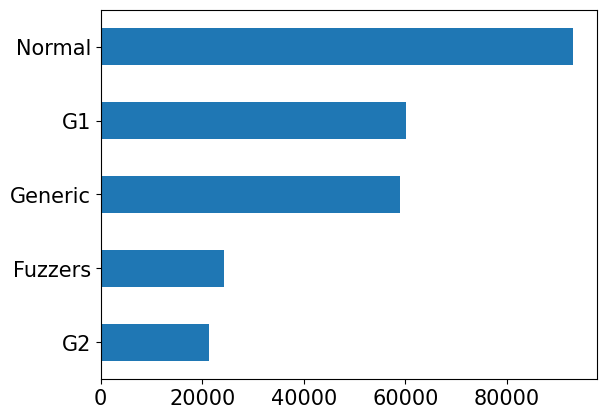

In [6]:
dataset_attack_cat = DataSet_UNSWNB15_attack_cat(UNSW_NB15_category)

number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
test_attack_cat_dataloader = DataLoader(dataset=dataset_attack_cat ,batch_size=batch_size ,shuffle=True)


Axes(0.22375,0.11;0.5775x0.77)


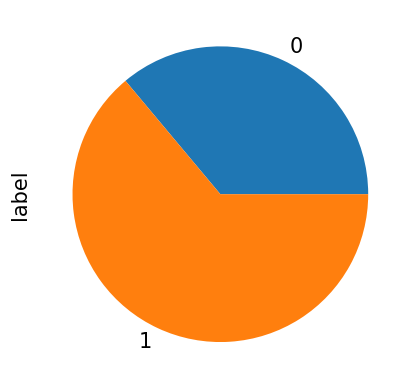

In [7]:
dataset_label = DataSet_UNSWNB15_label(UNSW_NB15_label)
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

train_label_dataloader = DataLoader(dataset=train_label ,batch_size=batch_size ,shuffle=True)
test_label_dataloader = DataLoader(dataset=dataset_attack_cat ,batch_size=batch_size ,shuffle=True)

In [8]:
class Model_Attack_Cat(nn.Module):

    def __init__(self):
        super(Model_Attack_Cat, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_attack_cat)
        )

    def forward(self,x):
        return self.layers(x)

class Model_Label(nn.Module):

    def __init__(self):
        super(Model_Label, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_label)
        )
      

    def forward(self,x):
         return self.layers(x)

In [9]:
my_model_attack = Model_Attack_Cat().to(device=device)
my_model_attack

Model_Attack_Cat(
  (layers): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [10]:
loss_fn1 = nn.CrossEntropyLoss()
loss_fn2 = nn.CrossEntropyLoss()
optimizer1 = opt.Adam(params=my_model_attack.parameters(),lr=lr)


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# **train attack cat**

In [12]:
my_model_attack.load_state_dict(torch.load("/content/model_attack_4_attack_category_as_G1_and_3_attack_category_as_G2_70_100.pth"))

<All keys matched successfully>

# **test attack cat**

In [13]:
correct = 0
y_test, yhat = list(), list()

tensor_G1_x, tensor_G1_y = list(), list()
tensor_G2_x, tensor_G2_y = list(), list()

for batch_x, labl in test_attack_cat_dataloader:
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_attack(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    # print(batch_x)
    # print(out[0])
    # print(labl[0])
    # print(predicted[0])

    for idx, x in enumerate(predicted.cpu().detach().numpy()):

      if x == 2: #g2
        tensor_G2_x.append(batch_x[idx])
        tensor_G2_y.append(labl[idx])

      elif x == 1: #g1
        tensor_G1_x.append(batch_x[idx])
        tensor_G1_y.append(labl[idx])

    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)
    

print("acc : %.2f" % (100.*correct / len(dataset_attack_cat)),end="")
print("%")

acc : 85.20%


Confusion matrix, without normalization
[[86896    32    65  1126  4881]
 [   39 57869   295   613    55]
 [  519    70 12573  8060   137]
 [  941   152 11031 47539   534]
 [ 6060    34  1968  1512 14672]]


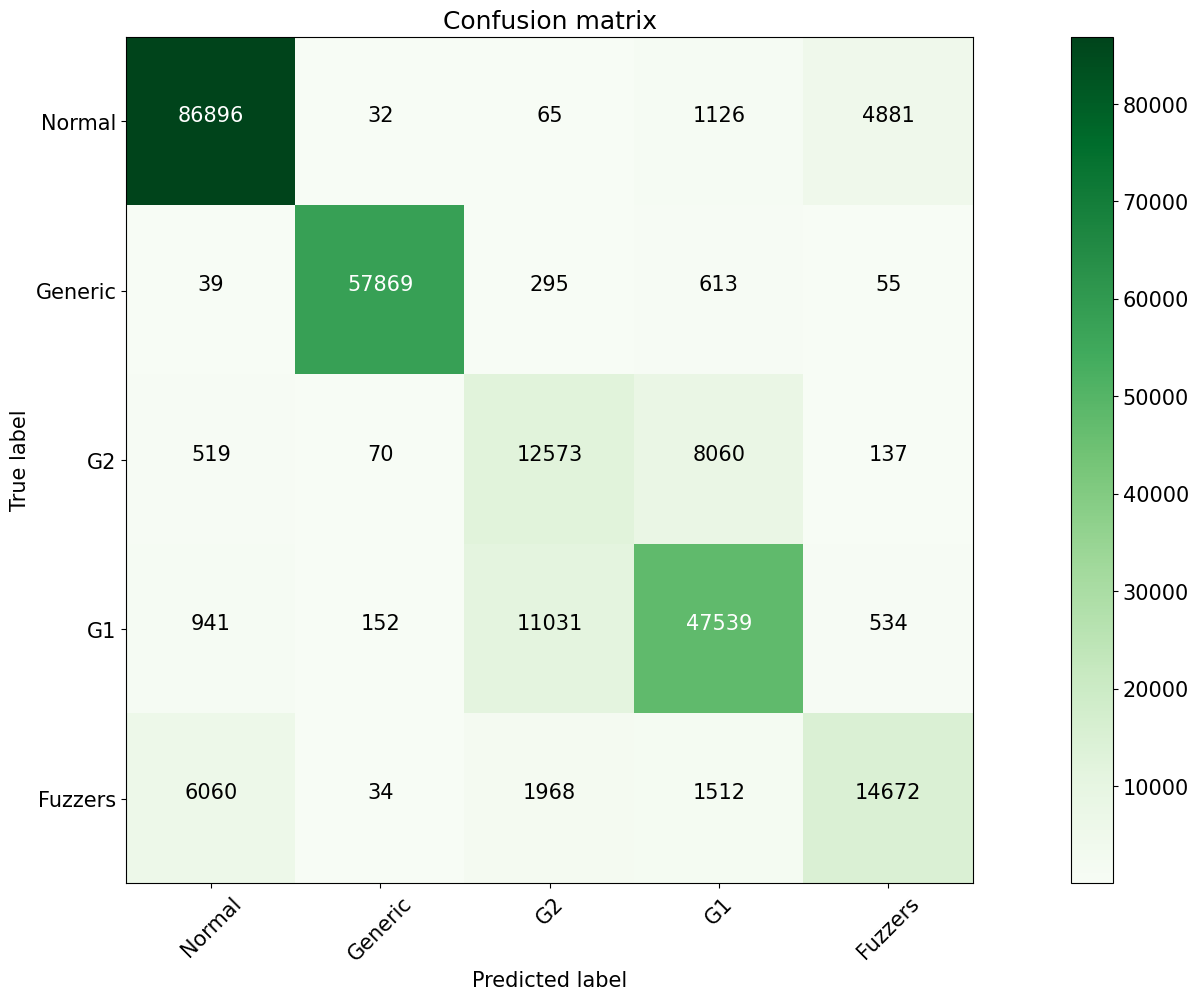

In [14]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[4,3,2,1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=['Normal','Generic','G2',"G1",'Fuzzers'],normalize= False,  title='Confusion matrix')

In [15]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.72      0.61      0.66     24246
           1       0.81      0.79      0.80     60197
           2       0.48      0.59      0.53     21359
           3       1.00      0.98      0.99     58871
           4       0.92      0.93      0.93     93000

    accuracy                           0.85    257673
   macro avg       0.79      0.78      0.78    257673
weighted avg       0.86      0.85      0.85    257673



In [16]:
print(len(tensor_G2_x))
print(len(tensor_G2_y))

print(len(tensor_G1_x))
print(len(tensor_G1_y))

print(type(tensor_G1_x))


25932
25932
58850
58850
<class 'list'>


In [17]:
UNSW_NB15 = pd.read_csv("/content/drive/MyDrive/UNSW_NB15.csv")


indexAge = UNSW_NB15[(UNSW_NB15['attack_cat'] == 'Normal') | (UNSW_NB15['attack_cat'] == 'Generic') | (UNSW_NB15['attack_cat'] == 'Fuzzers') | (UNSW_NB15['attack_cat'] == 'DoS') | (UNSW_NB15['attack_cat'] == 'Analysis') | (UNSW_NB15['attack_cat'] == 'Backdoor')].index
UNSW_NB15.drop(indexAge , inplace=True)

N = len(UNSW_NB15) - len(tensor_G1_x)
UNSW_NB15 = UNSW_NB15.iloc[N: , :]

UNSW_NB15

,Unnamed: 0,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
51563,51563,51564,0.000008,pup,-,INT,2,0,180,0,...,9,10,0,0,0,9,10,0,Reconnaissance,1
51564,51564,51565,1.080082,tcp,-,FIN,10,8,564,354,...,1,1,0,0,0,1,1,0,Reconnaissance,1
51565,51565,51566,0.623028,tcp,ftp-data,FIN,8,10,364,3754,...,1,2,0,0,0,2,1,0,Exploits,1
51566,51566,51567,0.000008,unas,-,INT,2,0,200,0,...,2,4,0,0,0,21,4,0,Exploits,1
51568,51568,51569,0.665349,tcp,-,FIN,10,8,564,354,...,1,1,0,0,0,1,1,0,Reconnaissance,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241182,241182,65842,0.205856,tcp,-,FIN,9,8,4764,434,...,1,1,0,0,0,1,1,0,Exploits,1
241183,241183,65843,0.000011,udp,-,INT,2,0,168,0,...,1,1,0,0,0,2,1,0,Reconnaissance,1
241184,241184,65844,0.642848,tcp,-,FIN,10,8,564,354,...,1,1,0,0,0,1,2,0,Reconnaissance,1
241186,241186,65846,0.671189,tcp,-,FIN,10,8,564,354,...,1,1,0,0,0,1,1,0,Reconnaissance,1


In [18]:
class DataSet_G1(Dataset):

    def __init__(self,list_x,list_y):

        self.data_array = list_x
        self.x = list_x
        self.y = list_y

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = self.x[item], self.y[item]
        return sample

In [19]:
dataset_g1 = DataSet_G1(tensor_G1_x,tensor_G1_y)
dataset_g1 = DataLoader(dataset=dataset_g1 ,batch_size=batch_size ,shuffle=True)

dataset_attack_cat =  DataSet__G1(UNSW_NB15)

number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
dataset_g1 = DataLoader(dataset=dataset_attack_cat ,batch_size=batch_size ,shuffle=True)

<ipython-input-5-12dc2dcef0e1>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)


In [20]:
my_model_attack_1 = Model_Attack_Cat().to(device=device)
my_model_attack_1.load_state_dict(torch.load("/content/train_G1_with_out_normals_category.pth"))

<All keys matched successfully>

In [21]:
correct = 0
y_test, yhat = list(), list()


for batch_x , labl in dataset_g1:
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_attack_1(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)+100
    
    print(batch_x)
    print(out)
    print(labl)
    print(predicted)
    print("--------------")

    for i in labl.cpu().detach().numpy():
        y_test.append(i)

    for i in predicted.cpu().detach().numpy():
        yhat.append(i)


print("acc : %.2f" % (100.*correct / (len(dataset_g1)*batch_size)),end="")
print("%")


tensor([[-0.2670,  0.5880,  1.1388,  ...,  1.6723, -0.1821,  0.0000],
        [ 0.1590,  0.2734, -0.7382,  ..., -0.4510, -0.5468,  0.0000],
        [-0.2670,  0.5430,  1.1388,  ..., -0.2387, -0.5468,  0.0000],
        ...,
        [-0.0855,  0.2734, -0.7382,  ..., -0.4510, -0.5468,  0.0000],
        [-0.2670,  0.5430,  1.1388,  ..., -0.4510, -0.1821,  0.0000],
        [-0.1251,  0.2734, -0.7382,  ..., -0.2387, -0.5468,  0.0000]],
       device='cuda:0')
tensor([[ 5.3066,  3.3072, -4.7078,  ..., -5.7471, -6.7177, -5.9044],
        [ 6.7032, -1.5591, -3.4263,  ..., -5.2225, -6.1391, -5.7860],
        [ 0.6847,  7.8592,  2.1671,  ..., -4.5128, -5.6061, -4.6381],
        ...,
        [ 1.2364,  8.0264,  0.6302,  ..., -4.7678, -5.8837, -4.8922],
        [ 3.6584,  1.5117,  5.6131,  ..., -5.6332, -6.9980, -6.1579],
        [ 5.8515,  0.8512, -3.4343,  ..., -5.4951, -6.4340, -5.8509]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0, 0, 1,  ..., 1, 2, 0], device='cuda:0')
tensor([

Confusion matrix, without normalization
[[    0     7     3   161]
 [    0  1133   123   207]
 [    0    74 10668  2963]
 [    0   206   635 42670]]


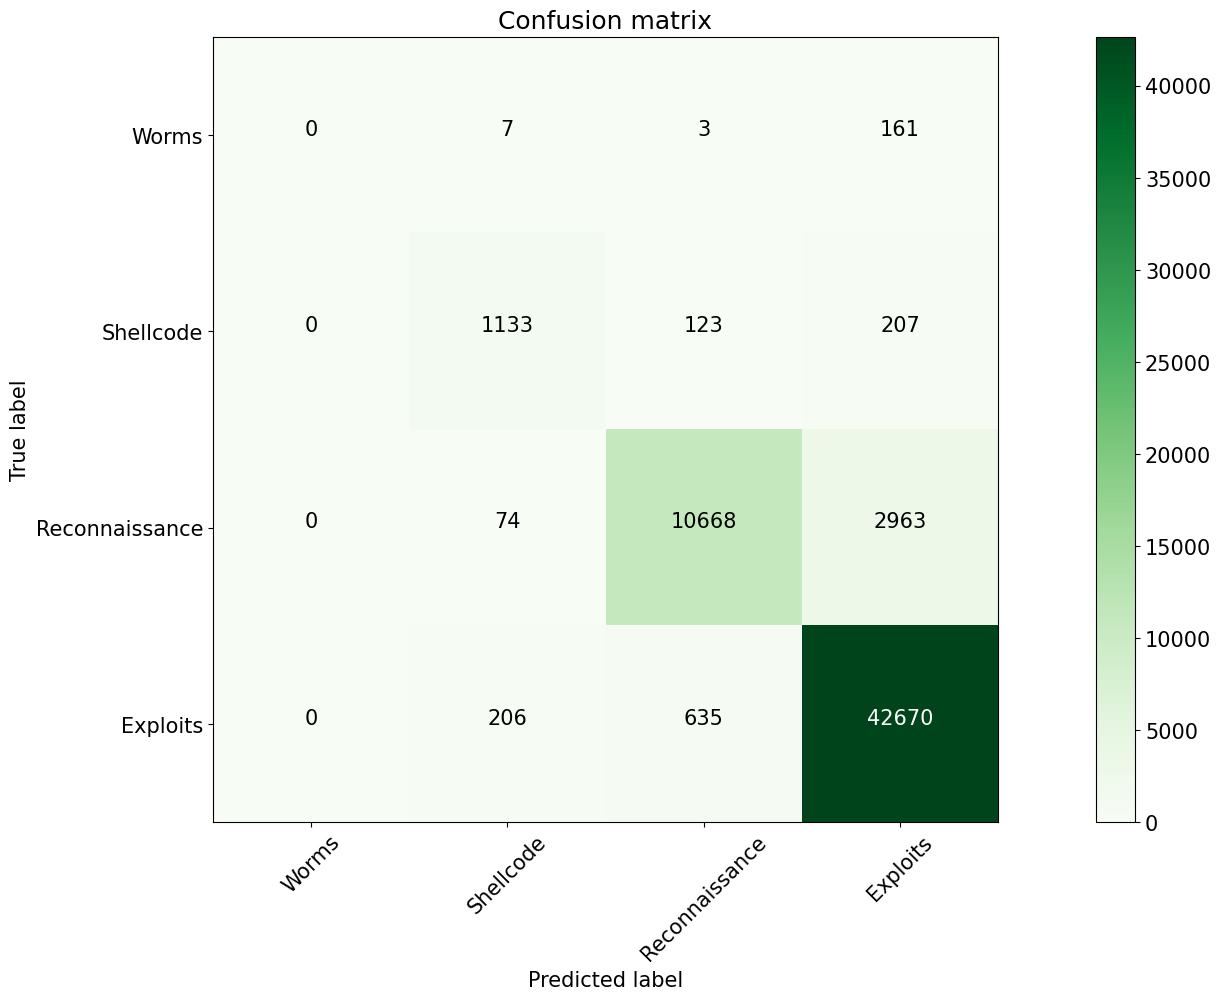

In [22]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[3,2,1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=['Worms','Shellcode','Reconnaissance','Exploits'],normalize= False,  title='Confusion matrix')

In [23]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     43511
           1       0.93      0.78      0.85     13705
           2       0.80      0.77      0.79      1463
           3       0.00      0.00      0.00       171

    accuracy                           0.93     58850
   macro avg       0.66      0.63      0.65     58850
weighted avg       0.92      0.93      0.92     58850



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
UNSW_NB15 = pd.read_csv("/content/drive/MyDrive/UNSW_NB15.csv")


indexAge = UNSW_NB15[(UNSW_NB15['attack_cat'] == 'Normal') | (UNSW_NB15['attack_cat'] == 'Generic') | (UNSW_NB15['attack_cat'] == 'Fuzzers') | (UNSW_NB15['attack_cat'] == 'Worms') | (UNSW_NB15['attack_cat'] == 'Exploits') | (UNSW_NB15['attack_cat'] == 'Reconnaissance') | (UNSW_NB15['attack_cat'] == 'Shellcode')].index
UNSW_NB15.drop(indexAge , inplace=True)

UNSW_NB15_category = UNSW_NB15.copy()
UNSW_NB15_label = UNSW_NB15.copy()

UNSW_NB15

,Unnamed: 0,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
47911,47911,47912,0.000009,ddp,-,INT,2,0,200,0,...,1,4,0,0,0,2,4,0,Backdoor,1
47912,47912,47913,0.000009,ipv6-frag,-,INT,2,0,200,0,...,2,7,0,0,0,2,7,0,Backdoor,1
47913,47913,47914,0.000009,cftp,-,INT,2,0,200,0,...,1,6,0,0,0,1,6,0,Backdoor,1
47914,47914,47915,0.000003,wsn,-,INT,2,0,200,0,...,2,7,0,0,0,2,6,0,Backdoor,1
47915,47915,47916,0.000008,pvp,-,INT,2,0,200,0,...,1,4,0,0,0,11,4,0,Backdoor,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241082,241082,65742,0.000004,unas,-,INT,2,0,200,0,...,4,4,0,0,0,8,11,0,DoS,1
241098,241098,65758,1.159325,tcp,-,FIN,26,24,3448,3188,...,1,1,0,0,0,2,1,0,DoS,1
241116,241116,65776,0.656699,tcp,-,FIN,10,8,830,1016,...,1,1,0,0,0,8,9,0,DoS,1
241120,241120,65780,0.235270,tcp,-,FIN,10,8,762,960,...,1,1,0,0,0,1,1,0,DoS,1


In [34]:
dataset_g2 = DataSet_G1(tensor_G2_x,tensor_G2_y)
dataset_g2 = DataLoader(dataset=dataset_g2 ,batch_size=batch_size ,shuffle=True)

dataset_attack_cat =  DataSet__G1(UNSW_NB15)

number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
dataset_g2 = DataLoader(dataset=dataset_attack_cat ,batch_size=batch_size ,shuffle=True)

In [35]:
my_model_attack_2 = Model_Attack_Cat().to(device=device)
my_model_attack_2.load_state_dict(torch.load("/content/train_G2_with_out_normals_category.pth"))

<All keys matched successfully>

In [39]:
correct = 0
y_test, yhat = list(), list()


for batch_x , labl in dataset_g2:
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_attack_2(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)+100
    
    print(batch_x)
    print(out)
    print(labl)
    print(predicted)
    print("--------------")

    for i in labl.cpu().detach().numpy():
        y_test.append(i)

    for i in predicted.cpu().detach().numpy():
        yhat.append(i)


print("acc : %.2f" % (100.*correct / (len(dataset_g2)*batch_size)),end="")
print("%")

tensor([[-0.2356, -0.8108,  0.4489,  ..., -0.6754, -0.4935,  0.0000],
        [-0.2356,  0.7209,  0.4489,  ...,  1.2924,  0.3418,  0.0000],
        [-0.2356,  0.7209,  0.4489,  ...,  0.1117,  2.0123,  0.0000],
        ...,
        [-0.2356,  0.2704,  0.4489,  ..., -0.2819,  0.6202,  0.0000],
        [-0.2356, -1.6217,  0.4489,  ..., -0.4786,  0.3418,  0.0000],
        [-0.1933,  0.5107, -1.5477,  ..., -0.6754, -1.0503,  0.0000]],
       device='cuda:0')
tensor([[ 2.2607,  2.2478,  4.3140,  ..., -4.8417, -4.9068, -5.1121],
        [ 2.2836,  2.3384,  4.2565,  ..., -4.8073, -4.8772, -5.0616],
        [ 2.2338,  2.2569,  4.3265,  ..., -4.8444, -4.9244, -5.1162],
        ...,
        [ 2.2398,  2.2633,  4.3245,  ..., -4.8462, -4.9234, -5.1153],
        [ 2.3423,  2.1517,  4.3025,  ..., -4.8409, -4.9032, -5.1061],
        [-1.0821,  0.1968,  4.9366,  ..., -4.3404, -4.3965, -4.5269]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([2, 0, 2,  ..., 2, 2, 2], device='cuda:0')
tensor([

Confusion matrix, without normalization
[[15948   255   150]
 [ 1904   320   105]
 [ 1828   175   674]]


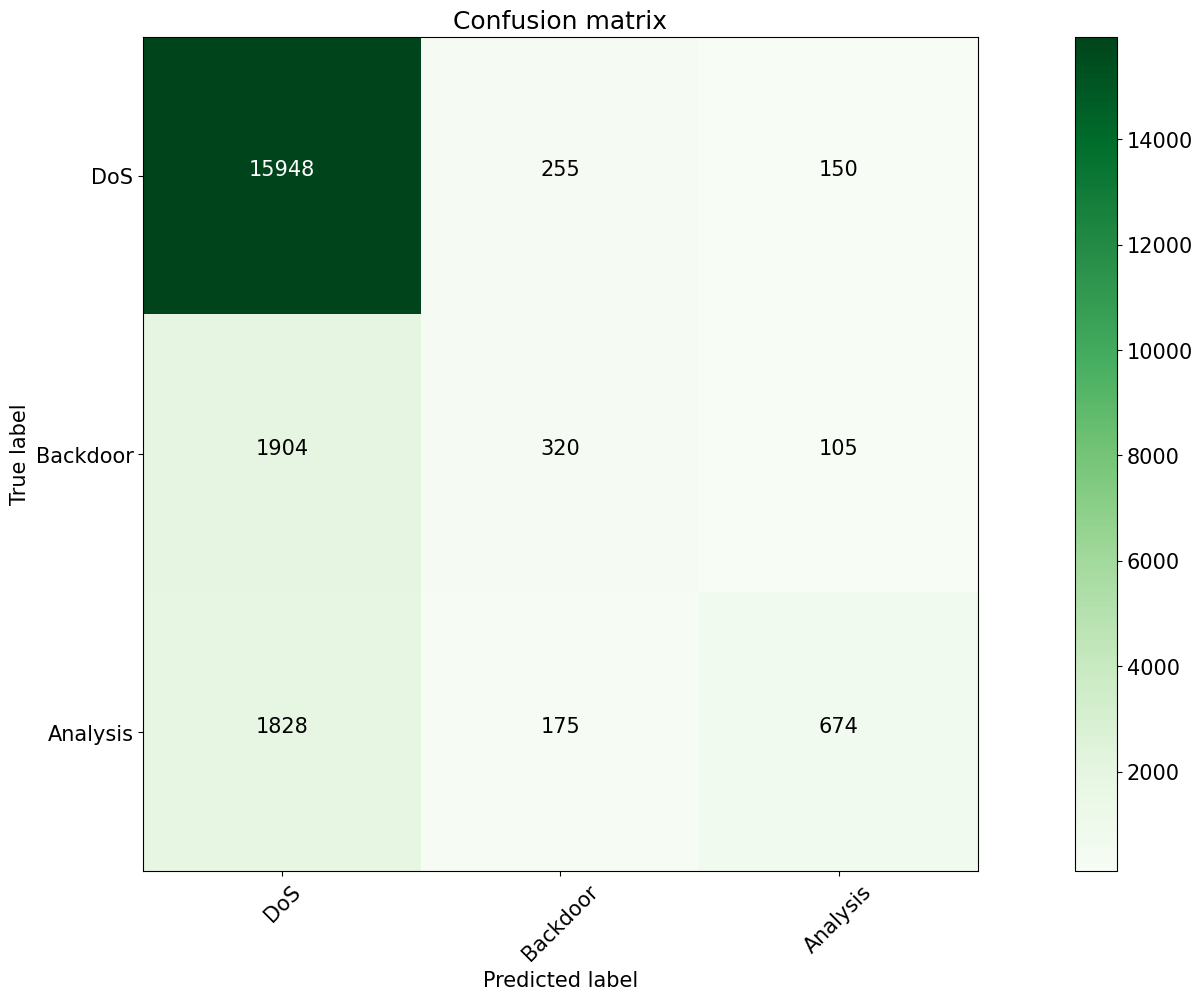

In [37]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=['DoS','Backdoor','Analysis'],normalize= False,  title='Confusion matrix')

In [38]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.73      0.25      0.37      2677
           1       0.43      0.14      0.21      2329
           2       0.81      0.98      0.89     16353

    accuracy                           0.79     21359
   macro avg       0.65      0.45      0.49     21359
weighted avg       0.76      0.79      0.75     21359

